# Plant Reccomender EDA

### Loading and Cleaning

In [214]:
from pathlib import Path
import polars as pl

src = "../raw_data"
dst = "../touched_data"

trust_path = src + "/trustworthy_plants.xlsx"

Load excel and select the colums I will use for the reccomender

In [215]:
trust_df = pl.read_excel(trust_path)

trust_df = trust_df.select(
        [
            pl.col("name").alias("scientific_name"),
            pl.col("commonName").alias("common_name"),
            pl.col("Family"),
            pl.col("Toxicity").alias("is_toxic"),
            pl.col("brightness").alias("light_level"),
            pl.col("watering").alias("water_need"),
            pl.col("solHumidity").alias("humidity_need"),
            pl.col("temperature").alias("temp_tolerance"),
            pl.col("Flower").alias("has_flowers"),
            pl.col("description"),
            pl.col("General care"),
        ]
    )

Could not determine dtype for column 7, falling back to string


Could not determine dtype for column 9, falling back to string


Clean and Patch Numeric Columns for light_level, temp_tolerance, and humidity_need


In [216]:
def clean_light_col(col_name):
    return (
        pl.col(col_name)
        .cast(pl.String)
        # Fix: Excel converted ranges (e.g., 3-4) into dates
        .str.replace(r"2022-04-03.*", "3_4")
        .str.replace(r"2022-03-01.*", "1_3")
        # Fix: Normalize descriptive text to numeric strings
        .str.replace(r"^1-3.*", "1_3")
        .str.replace(r"(?i).*Bright indirect.*", "2")
        .str.replace(r"2\(.*", "2")
        # Format: Standardize delimiters to underscore for splitting
        .str.replace_all(r"[, \-]+", "_")
        # Calc: Convert string range to average float
        .str.split("_")
        .list.eval(pl.element().cast(pl.Float64, strict=False))
        .list.mean()
    )

def clean_humidity_col(col_name):
    return (
        pl.col(col_name)
        .cast(pl.String)
        # Fix: Normalize descriptive text to numeric strings
        .str.replace(r"Average:.*", "2")
        # Calc: Convert string range to average float
        .str.split("_")
        .list.eval(pl.element().cast(pl.Float64, strict=False))
        .list.mean()
    )


def clean_temp_col(col_name):
    return (
        pl.col(col_name)
        .cast(pl.String)
        # Fix: Normalize descriptive text to numeric strings
        .str.replace(r"Average:.*", "2")
        # Format: Standardize delimiters to underscore for splitting
        .str.replace_all(r"[, \-]+", "_")
        # Calc: Convert string range to average float
        .str.split("_")
        .list.eval(pl.element().cast(pl.Float64, strict=False))
        .list.mean()
    )

# Clean and Patch Numeric Columns
trust_df = trust_df.with_columns(
    [clean_light_col("light_level"), clean_humidity_col("humidity_need"), clean_temp_col("temp_tolerance")]
)
# Patches for missing values
trust_df = trust_df.with_columns(
    pl.when(pl.col("scientific_name") == "Philodendron hederaceum")
    .then(2.5)
    .when(pl.col("scientific_name") == "Hydrangea hortensia")
    .then(1.5)
    .otherwise(pl.col("light_level"))
    .alias("light_level"),
    pl.when(pl.col("scientific_name") == "Hydrangea hortensia")
    .then(1.0)
    .when(pl.col("scientific_name") == "Pachira aquatiac")
    .then(1.0)
    .when(pl.col("scientific_name") == "Philodendron hederaceum")
    .then(2.0)
    .otherwise(pl.col("humidity_need"))
    .alias("humidity_need"),
    pl.when(pl.col("scientific_name") == "Hydrangea hortensia")
    .then(1.0)
    .when(pl.col("scientific_name") == "Pachira aquatiac")
    .then(2.0)
    .when(pl.col("scientific_name") == "Philodendron hederaceum")
    .then(2.0)
    .otherwise(pl.col("temp_tolerance"))
    .alias("temp_tolerance"),
)

Convert the weird messy Toxicity column into a boolean (Kinda unsafe still)

Assumes that the nulls are non-toxic

In [217]:
trust_df = trust_df.with_columns(
        pl.when(pl.col("is_toxic").fill_null("Safe").str.contains(r"(?i)toxic|poisonous"))
        .then(1)
        .otherwise(0)
        .alias("is_toxic")
    )

Fill some missing values for water_need

In [218]:
trust_df = trust_df.with_columns(
        pl.when(
            pl.col("scientific_name").str.contains(
                r"(?i)Sansevieria|Haworthia|Sedum|Sempervivum|Dyckia|Euphorbia|Pachyphytum|Stapelia"
            )
        )
        .then(3)
        .when(pl.col("scientific_name").str.contains(r"(?i)Ficus|Monstera|Pachira|Pellionia|Philodendron"))
        .then(2)
        .when(pl.col("scientific_name").str.contains(r"(?i)Pellaea|Hydrangea|Paphiopedilum"))
        .then(1)
        .otherwise(pl.col("water_need"))
        .alias("water_need")
    )

The has\_flowers column is strange as it only had 2 entries in the initial data. I decided I would fill it in manually based on the **plant's primary ornamental purpose**, classifying it as '1' (Flowering) if it is commonly grown for its blooms, or '0' (Foliage) if it is grown for its leaves and structure.

In [219]:
# Plants primarily grown for their blooms
FLOWERING_SIGNALS = [
    "Orchidaceae", "Gesneriaceae", "Begoniaceae", "Malvaceae",
    "Bromeliaceae", "Anthurium", "Spathiphyllum", "Hibiscus",
    "Kalanchoe", "Lily", "Hydrangea", "Pelargonium",
    "Cyclamen", "Azalea", "Allamanda", "Aphelandra",
    "Beloperone", "Bougainvillea", "Calceolaria", "Carissa",
    "Catharanthus", "Chrysanthemum", "Citrofortunella", "Clerodendrum",
    "Colummea", "Crossandra", "Fuchsia", "Guzmania",
    "Hippeastrum", "Hoya", "Hyacinthus", "Impatiens",
    "Ixora", "Jatropha", "Justicia", "Manettia",
    "Nautilocalyx", "Pachystachys", "Pentas", "Rhododendron",
    "Ruellia", "Schlumbergera", "Sinningia", "Stephanotis",
    "Tillandsia", "Trillandsia", "Vriesea", "Zygocactus",
    "Aechmea", "Billbergia", "Cryptanthus", "Neoregelia",
    "Nidularium", "Malvaviscus", "Ardissa", "Abutilon hybridum",
]

# Common names that imply flowers
FLOWERING_COMMON = ["Flower", "Bloom", "Lily", "Orchid", "Rose", "Violet"]

# Plants primarily grown for foliage (technically can flower)
FOLIAGE_SIGNALS = [
    "Araceae", "Arecaceae", "Pteridaceae", "Aspleniaceae",
    "Polypodiaceae", "Asparagaceae", "Moraceae", "Piperaceae",
    "Araliaceae", "Ficus", "Philodendron", "Monstera",
    "Epipremnum", "Dracaena", "Sansevieria", "Hedera", "Syngonium",
    "Dieffenbachia", "Peperomia", "Acorus", "Adromischus",
    "Aloe", "Araucaria", "Ardisia", "Astrophytum",
    "Brassaia", "Calathea", "Callisia", "Cereus",
    "Ceropegia", "Chlorophytum", "Cissus", "Codiaeum",
    "Coffea", "Coleus", "Cordyline", "Crassula",
    "Cyperus", "Dizygotheca", "Dyckia", "Echeveria",
    "Echinocereus", "Euphorbia", "Fatsia", "Fittonia",
    "Gasteria", "Graptopetalum", "Gynura", "Haworthia",
    "Hemigraphis", "Mammillaria", "Maranta", "Mikania",
    "Opuntia", "Oxalis", "Pachira", "Pachyphytum",
    "Pellionia", "Pilea", "Plectranthus", "Podocarpus",
    "Polyscias", "Saxifraga", "Schefflera", "Scheflera",
    "Sedum", "Sempervivum", "Setcreasea", "Soleirolia",
    "Stapelia", "Strobilanthes", "Tolmiea", "Tradescantia",
    "Yucca", "Zebrina", "Scindapsus", "Nephrolepis",
]

# Common names that imply foliage
FOLIAGE_COMMON = ["Fern", "Palm", "Ivy", "Pothos", "Fig", "Rubber"]

foliage_list_safe = [x for x in FOLIAGE_SIGNALS if x != "Euphorbia"]

re_flowering = r"(?i)" + "|".join(FLOWERING_SIGNALS)
re_flowering_common = r"(?i)" + "|".join(FLOWERING_COMMON)
re_foliage = r"(?i)" + "|".join(foliage_list_safe)
re_foliage_common = r"(?i)" + "|".join(FOLIAGE_COMMON)

trust_df = trust_df.with_columns(
    pl.when(pl.col("scientific_name").str.contains(r"(?i)Abutilon hybridum"))
    .then(1) # The one that already exists convert to number
    .when(pl.col("has_flowers").is_not_null())
    .then(pl.col("has_flowers"))  # Keep existing data if present
    # -- EXCEPTIONS --
    # Euphorbia Split: Poinsettia/Milii are flowers, generic Euphorbia is foliage
    .when(pl.col("scientific_name").str.contains(r"(?i)Euphorbia pulcherrima|Euphorbia milii"))
    .then(1)
    .when(pl.col("scientific_name").str.contains(r"(?i)Euphorbia"))
    .then(0)
    # -- FLOWERING LISTS --
    .when(pl.col("scientific_name").str.contains(re_flowering) | pl.col("Family").str.contains(re_flowering))
    .then(1)
    # -- FOLIAGE LISTS --
    .when(pl.col("scientific_name").str.contains(re_foliage) | pl.col("Family").str.contains(re_foliage))
    .then(0)
    # -- COMMON NAMES --
    .when(pl.col("common_name").str.contains(re_flowering_common))
    .then(1)
    .when(pl.col("common_name").str.contains(re_foliage_common))
    .then(0)
    .otherwise(pl.col("has_flowers"))
    .alias("has_flowers")
)
trust_df = trust_df.with_columns(
    pl.col("has_flowers").cast(pl.Int64, strict=False).fill_null(0)
)

# We dont need the family anymore
trust_df = trust_df.drop("Family")

Data cleaning done... Some extra checks and visuals

In [220]:
import duckdb as dd

con = dd.connect()

con.sql("CREATE TABLE trustworthy_plants AS SELECT * FROM trust_df")

tables_df = con.sql("SHOW TABLES").pl()

for table_name in tables_df["name"]:
    header = f" TABLE: {table_name.upper()} "
    print("\n" + "=" * len(header))
    print(header)
    print("=" * len(header))

    schema_df = con.sql(f"DESCRIBE '{table_name}'").pl()

    for col_info in schema_df.to_dicts():
        print(f"  - {col_info['column_name']}: {col_info['column_type']}")


 TABLE: TRUSTWORTHY_PLANTS 
  - scientific_name: VARCHAR
  - common_name: VARCHAR
  - is_toxic: INTEGER
  - light_level: DOUBLE
  - water_need: BIGINT
  - humidity_need: DOUBLE
  - temp_tolerance: DOUBLE
  - has_flowers: BIGINT
  - description: VARCHAR
  - General care: VARCHAR


In [221]:
con.sql("""
        SELECT *
        FROM trustworthy_plants
        """)

┌────────────────────────────┬─────────────────────────────────────────────────────────────┬──────────┬─────────────┬────────────┬───────────────┬────────────────┬─────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│      scientific_name       │                         c

In [222]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")


pl.Config.set_tbl_cols(-1)
print("\n--- Statistical Summary for Features ---")
summary_df = con.sql("""
    SUMMARIZE
        SELECT
            light_level,
            water_need,
            humidity_need,
            temp_tolerance,
            is_toxic,
            has_flowers
        FROM trustworthy_plants
""").pl()

print(summary_df.drop("null_percentage", "count"))


--- Statistical Summary for Features ---
shape: (6, 10)
┌───────────────┬─────────────┬─────┬─────┬───────────────┬───────┬──────────────┬─────┬─────┬─────┐
│ column_name   ┆ column_type ┆ min ┆ max ┆ approx_unique ┆ avg   ┆ std          ┆ q25 ┆ q50 ┆ q75 │
│ ---           ┆ ---         ┆ --- ┆ --- ┆ ---           ┆ ---   ┆ ---          ┆ --- ┆ --- ┆ --- │
│ str           ┆ str         ┆ str ┆ str ┆ i64           ┆ str   ┆ str          ┆ str ┆ str ┆ str │
╞═══════════════╪═════════════╪═════╪═════╪═══════════════╪═══════╪══════════════╪═════╪═════╪═════╡
│ light_level   ┆ DOUBLE      ┆ 1.0 ┆ 3.5 ┆ 6             ┆ 2.222 ┆ 0.5771032773 ┆ 2.0 ┆ 2.5 ┆ 2.5 │
│               ┆             ┆     ┆     ┆               ┆       ┆ 872323       ┆     ┆     ┆     │
│ water_need    ┆ BIGINT      ┆ 1   ┆ 3   ┆ 3             ┆ 1.94  ┆ 0.6212437324 ┆ 2   ┆ 2   ┆ 2   │
│               ┆             ┆     ┆     ┆               ┆       ┆ 435571       ┆     ┆     ┆     │
│ humidity_need ┆ DOUBLE      ┆ 1.

--- Generating distribution plots ---
Saved feature_distributions.png


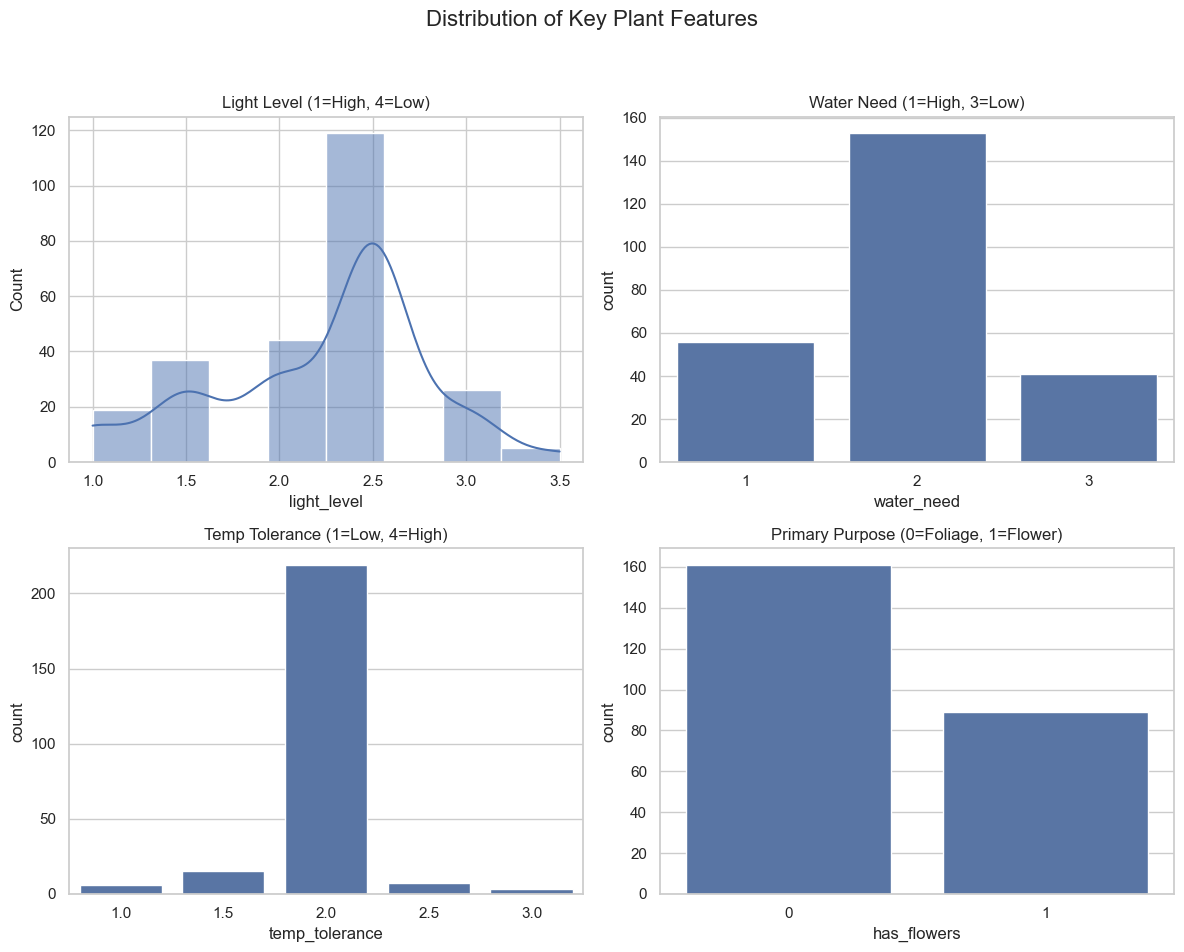

In [223]:
plot_df = con.sql("""
    SELECT 
        light_level, 
        water_need,
        temp_tolerance,
        humidity_need, 
        is_toxic, 
        has_flowers 
    FROM trustworthy_plants
""").to_df()

print("--- Generating distribution plots ---")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Distribution of Key Plant Features", fontsize=16)

# Light Level (Histogram)
sns.histplot(plot_df['light_level'], kde=True, ax=axes[0, 0], bins=8)
axes[0, 0].set_title("Light Level (1=High, 4=Low)")

# Water Need
sns.countplot(x='water_need', data=plot_df, ax=axes[0, 1])
axes[0, 1].set_title("Water Need (1=High, 3=Low)")

# Temp Tolerance
sns.countplot(x='temp_tolerance', data=plot_df, ax=axes[1, 0])
axes[1, 0].set_title("Temp Tolerance (1=Low, 4=High)")

# Has Flowers
sns.countplot(x='has_flowers', data=plot_df, ax=axes[1, 1])
axes[1, 1].set_title("Primary Purpose (0=Foliage, 1=Flower)")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
print("Saved feature_distributions.png")

Saved correlation_heatmap.png


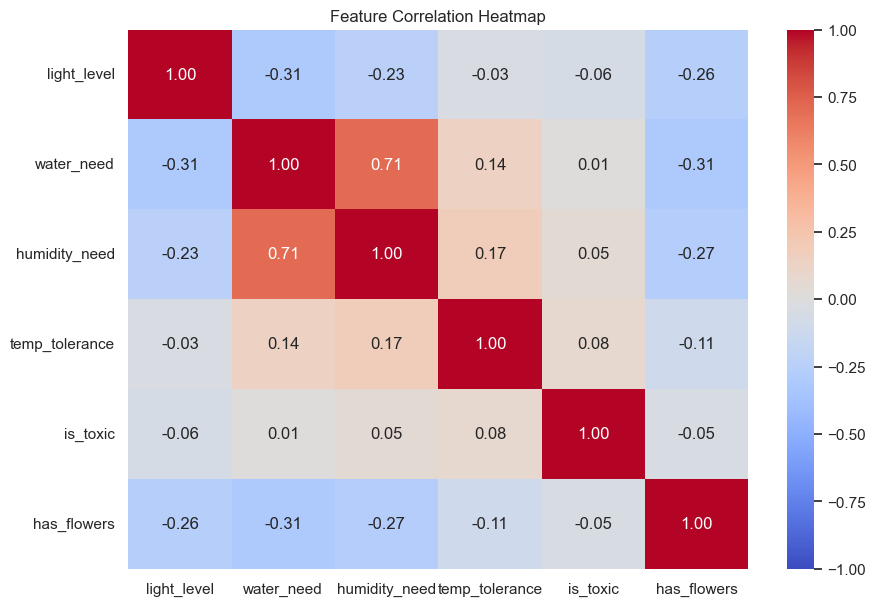

In [224]:
corr_df = plot_df[['light_level', 'water_need', 'humidity_need', 'temp_tolerance', 'is_toxic', 'has_flowers']]
corr_matrix = corr_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
print("Saved correlation_heatmap.png")

[Text(0, 0, '1 - High'), Text(1, 0, '2 - Medium'), Text(2, 0, '3 - Low')]

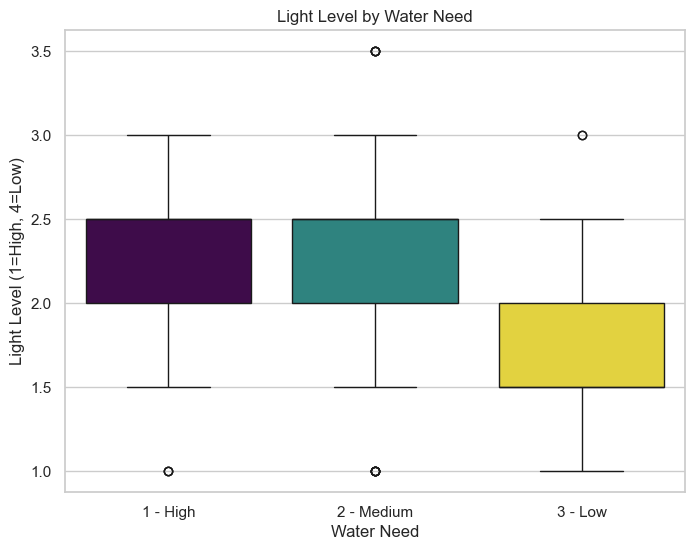

In [227]:
plt.figure(figsize=(8, 6))

# Create the boxplot
ax = sns.boxplot(
    x='water_need',
    y='light_level',
    data=plot_df,
    palette="viridis",
    hue='water_need',
    legend=False
)

plt.title("Light Level by Water Need")
plt.xlabel("Water Need")
plt.ylabel("Light Level (1=High, 4=Low)")

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['1 - High', '2 - Medium', '3 - Low'])